In [119]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from binance_utils import *
import statsmodels.api as sm
from keras.models import load_model
import dask.dataframe as dd

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [201]:
# Cargar datos:
df = pd.read_parquet('datasets/merged_data.parquet')

# Establecer 'timestamp' como índice:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Análisis Exploratorio de Datos

## Validación de datos

In [121]:
# Calcular las diferencias en segundos
time_diff_seconds = df.index.to_series().diff().dt.total_seconds()

# Calcular la media de las diferencias
time_mean_diff_seconds = time_diff_seconds.mean()
print("Frecuencia entre observaciones, en segundos: ", time_mean_diff_seconds)

Frecuencia entre observaciones, en segundos:  0.5032822274653643


In [122]:
# Revisamos valores nulos:
null_values = df.isnull().sum()
columns_with_nulls = null_values[null_values > 0]

if not columns_with_nulls.empty:
    print(columns_with_nulls)
else:
    print("No hay valores nulos en el DataFrame.")

No hay valores nulos en el DataFrame.


In [123]:
# # Revisamos filas duplicadas:
# duplicated_rows = df.duplicated().sum()

# if duplicated_rows > 0:
#     duplicated_pct = duplicated_rows / len(df)
#     print(f"Porcentaje de observaciones duplicadas: {duplicated_pct:.2%}")
# else:
#     print("No hay observaciones duplicadas en el DataFrame.")

In [124]:
# Validar consistencia de 'timestamp':
time_diff = df.index.to_series().diff().value_counts()
print(time_diff)

timestamp
0 days 00:00:00.500000768    406877
0 days 00:00:00.500001024    386927
0 days 00:00:00.500001280    375101
0 days 00:00:00.500001536    333432
0 days 00:00:00.500002048    310141
0 days 00:00:00.500000512    244268
0 days 00:00:00.500001792    222360
0 days 00:00:00.500002304    180051
0 days 00:00:00.500002816     99929
0 days 00:00:00.500000256     79793
0 days 00:00:00.500002560     63101
0 days 00:00:00.500003072     32115
0 days 00:00:00.500000         9791
0 days 00:00:00.500003328      1674
0 days 00:10:00.919105024         1
0 days 00:10:00.694799616         1
0 days 00:10:00.684328448         1
0 days 00:10:00.645758208         1
0 days 00:10:02.370601728         1
0 days 00:10:01.053577728         1
0 days 00:10:00.838393856         1
0 days 00:10:00.735068928         1
0 days 00:10:01.408174336         1
0 days 00:10:00.803035904         1
0 days 00:10:00.872205568         1
0 days 00:10:00.729733376         1
0 days 00:10:01.093585664         1
0 days 00:10:01.14

En `time_diff` también se observan saltos temporales atípicos de 10 minutos. Investigamos su naturaleza.

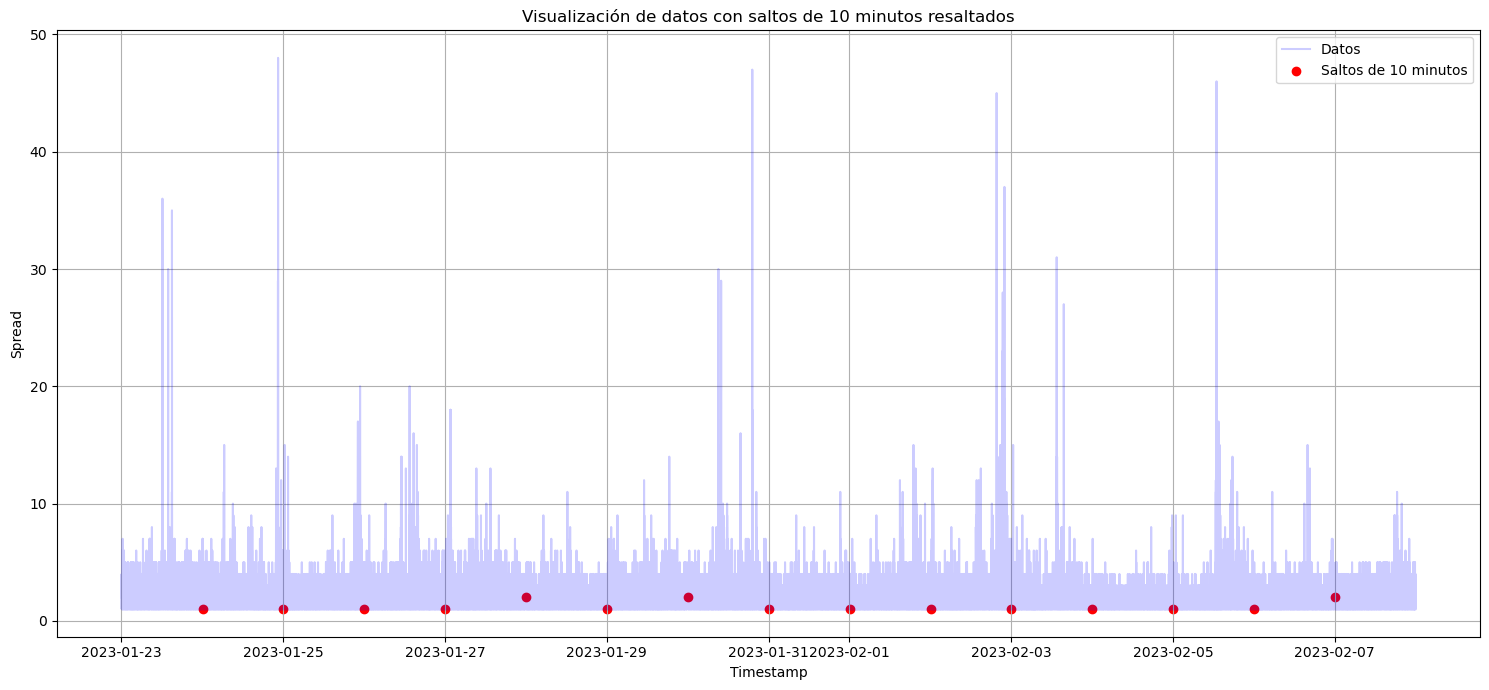

In [125]:
# Asegurarse de que los datos estén ordenados por timestamp:
df_10min = df.reset_index().sort_values(by='timestamp')

# Calcular la diferencia entre timestamps consecutivos:
df_10min['time_diff'] = df_10min['timestamp'].diff()

# Identificar los puntos de interés:
mask = df_10min['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Graficar los datos:
plt.figure(figsize=(15, 7))
plt.plot(df_10min['timestamp'], df_10min['spread'], label='Datos', color='blue', alpha=0.2)
plt.scatter(df_10min[mask]['timestamp'], df_10min[mask]['spread'], color='red', label='Saltos de 10 minutos')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.title('Visualización de datos con saltos de 10 minutos resaltados')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [126]:
# Calcular la diferencia entre timestamps consecutivos:
df_10min['time_diff'] = df_10min['timestamp'].diff()

# Identificar los puntos de interés:
mask = df_10min['time_diff'].abs().between(pd.Timedelta('9 minutes 50 seconds'), pd.Timedelta('10 minutes 10 seconds'))

# Crear una máscara para los puntos inmediatamente posteriores:
next_mask = mask.shift(-1, fill_value=False)

# Combinar las dos máscaras usando el operador "or":
combined_mask = mask | next_mask

# Extraer estos puntos en un nuevo DataFrame:
df_10min_timeskips = df_10min[combined_mask].copy()

df_10min_timeskips.sort_values('timestamp', ascending=True, inplace=True)
df_10min_timeskips.set_index('timestamp', inplace=True)

print("Saltos de 10 minutos detectados:\n", df_10min_timeskips.index)


Saltos de 10 minutos detectados:
 DatetimeIndex(['2023-01-23 23:54:59.459493120',
               '2023-01-24 00:05:00.602287104',
               '2023-01-24 23:54:59.469715200',
               '2023-01-25 00:05:00.563300864',
               '2023-01-25 23:54:59.934701568',
               '2023-01-26 00:05:00.664434944',
               '2023-01-26 23:54:59.788566016',
               '2023-01-27 00:05:00.626959872',
               '2023-01-27 23:54:59.901041408',
               '2023-01-28 00:05:00.773246976',
               '2023-01-28 23:54:59.843753472',
               '2023-01-29 00:05:00.646789376',
               '2023-01-29 23:54:59.372211712',
               '2023-01-30 00:05:00.780386048',
               '2023-01-30 23:54:59.890614528',
               '2023-01-31 00:05:00.625683456',
               '2023-01-31 23:54:59.606319360',
               '2023-02-01 00:05:00.659897088',
               '2023-02-01 23:54:58.416104192',
               '2023-02-02 00:05:00.786705920',
      

Los saltos temporales de 10 minutos ocurren cada vez entre las `23:55:00` y las `00:05:00`. Esto puede tratarse a cierres temporales programados en el sistema de recolección de datos.

### Eliminación de valores atípicos

En este enfoque, consideramos la no eliminación de valores atípicos, pues su presencia garantiza una granularidad media de 0.5 segundos, lo cual es deseado para el entrenamiento de la red LSTM.

Dado que estamos trabajando con una red LSTM para predicciones de series temporales, la consistencia y granularidad de los datos son cruciales. Las LSTMs son sensibles a la secuencia y orden de los datos. Si la eliminación de outliers causa brechas significativas en tus datos, podría ser beneficioso mantenerlos, especialmente si los outliers representan eventos reales.

Sin embargo, al decidir mantener los outliers, es importante tener en cuenta cómo el modelo responde a ellos durante el entrenamiento y validación. Podríamos considerar técnicas como la regularización para evitar el sobreajuste.

Una estrategia intermedia podría ser no eliminar completamente los outliers, sino más bien suavizarlos o ajustarlos a un valor menos extremo, preservando así la granularidad de los datos mientras reducimos el impacto del ruido.

### Visualizaciones

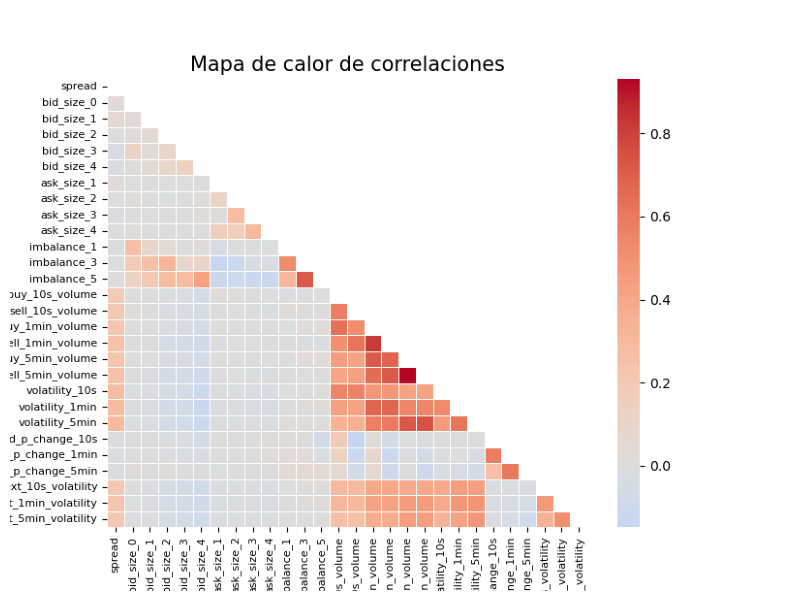

In [127]:
# # Mapa de calor
# corr = df.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
# plt.figure(figsize=(8, 6))
# sns.heatmap(data=corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5, annot=False)
# plt.title('Mapa de calor de correlaciones', size=15)
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# plt.savefig('images/heatmap_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/heatmap_all_outs.png')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

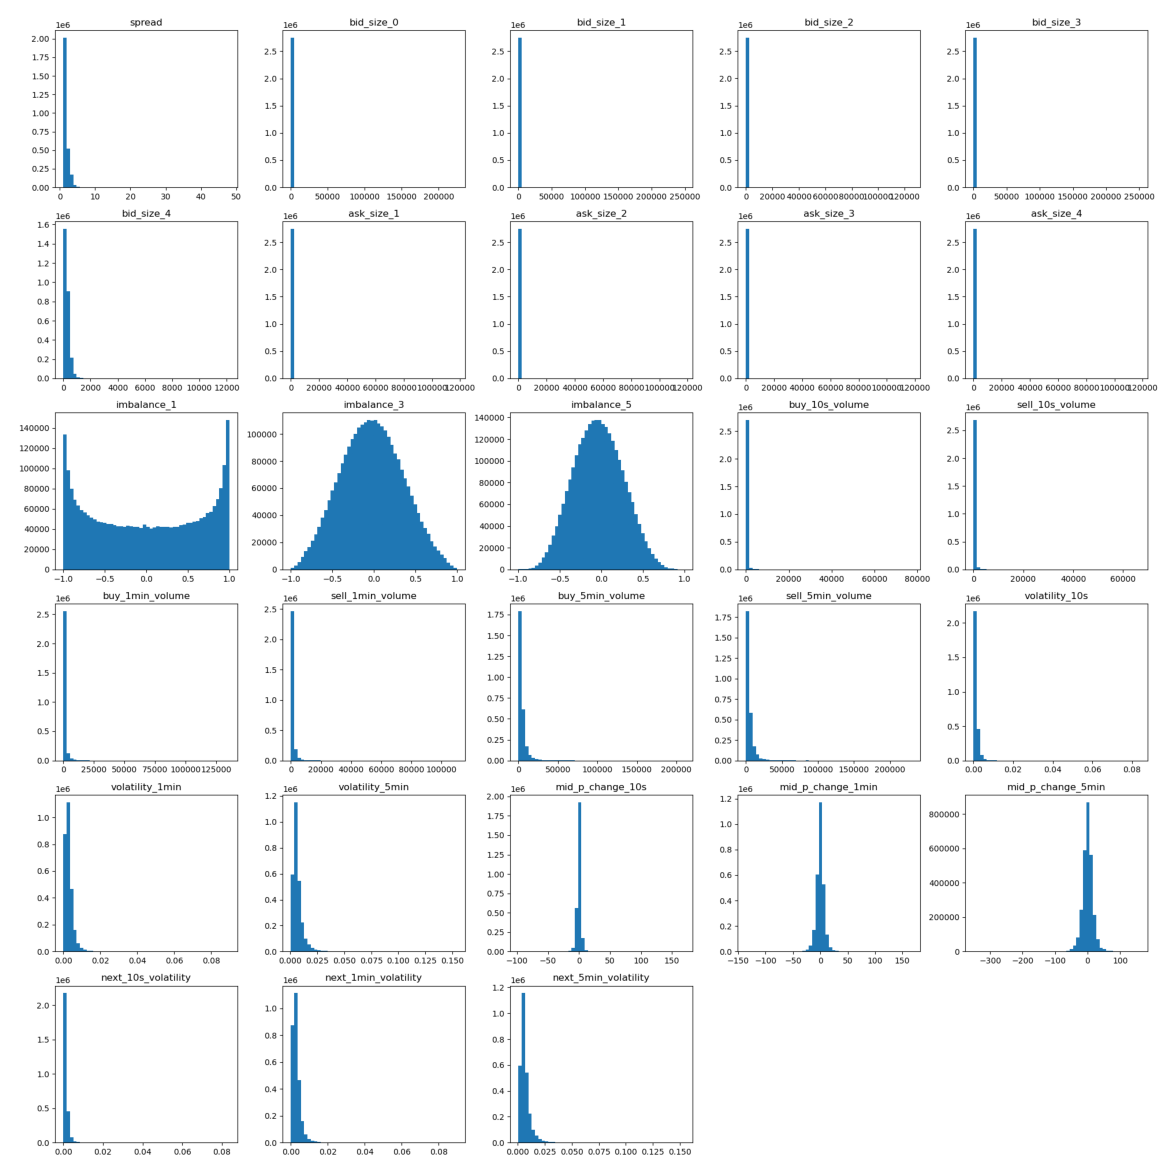

In [128]:
# # Plotear histogramas de cada variable:
# df.hist(figsize=(20, 20), bins=50, grid=False)
# plt.tight_layout()
# plt.savefig('images/hists_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/hists_all_outs.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis('off')
plt.show()

Notamos una distribución extraña de la variable objetivo, `mid_p_change_10s`. Efectuamos algunos tests estadísticos para chequear su normalidad, sesgo y curtosis.

In [129]:
import scipy.stats as stats

target_var = 'mid_p_change_10s'

Y = df[target_var]

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(Y)
print(f"Shapiro-Wilk Statistic: {shapiro_stat}, p-value: {shapiro_p}")

# Kurtosis y Asimetría
kurtosis_val = stats.kurtosis(Y)
skewness_val = stats.skew(Y)
print(f"Kurtosis: {kurtosis_val}")
print(f"Skewness: {skewness_val}")

# Test de Anderson-Darling
anderson_result = stats.anderson(Y)
print(f"Anderson-Darling Statistic: {anderson_result.statistic}")
for i in range(len(anderson_result.critical_values)):
    sl, cv = anderson_result.significance_level[i], anderson_result.critical_values[i]
    if anderson_result.statistic < cv:
        print(f"Significance Level: {sl}, Critical Value: {cv} - Se observa una distribución normal")
    else:
        print(f"Significance Level: {sl}, Critical Value: {cv} - No se observa una distribución normal")

c:\condaenvs\dsenv\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Statistic: 0.849754810333252, p-value: 0.0
Kurtosis: 49.91505384240342
Skewness: 0.3062055895713917
Anderson-Darling Statistic: 72958.70130326273
Significance Level: 15.0, Critical Value: 0.576 - No se observa una distribución normal
Significance Level: 10.0, Critical Value: 0.656 - No se observa una distribución normal
Significance Level: 5.0, Critical Value: 0.787 - No se observa una distribución normal
Significance Level: 2.5, Critical Value: 0.918 - No se observa una distribución normal
Significance Level: 1.0, Critical Value: 1.092 - No se observa una distribución normal


La prueba de Shapiro-Wilk arrojó un estadístico de 0.8498 y un valor p de 0.0, lo que indica que la distribución no es normal. Además, la kurtosis de la distribución es de 49.9151, lo que sugiere una alta concentración de los datos alrededor de la media, y una asimetría (skewness) de 0.3062, lo que indica una ligera inclinación hacia la derecha. La prueba de Anderson-Darling, que es otra prueba de normalidad, dio un estadístico de 72958.7013. Al evaluar diferentes niveles de significancia, desde el 15% hasta el 1%, en todos los casos los valores críticos (desde 0.576 hasta 1.092) sugieren que no se observa una distribución normal.

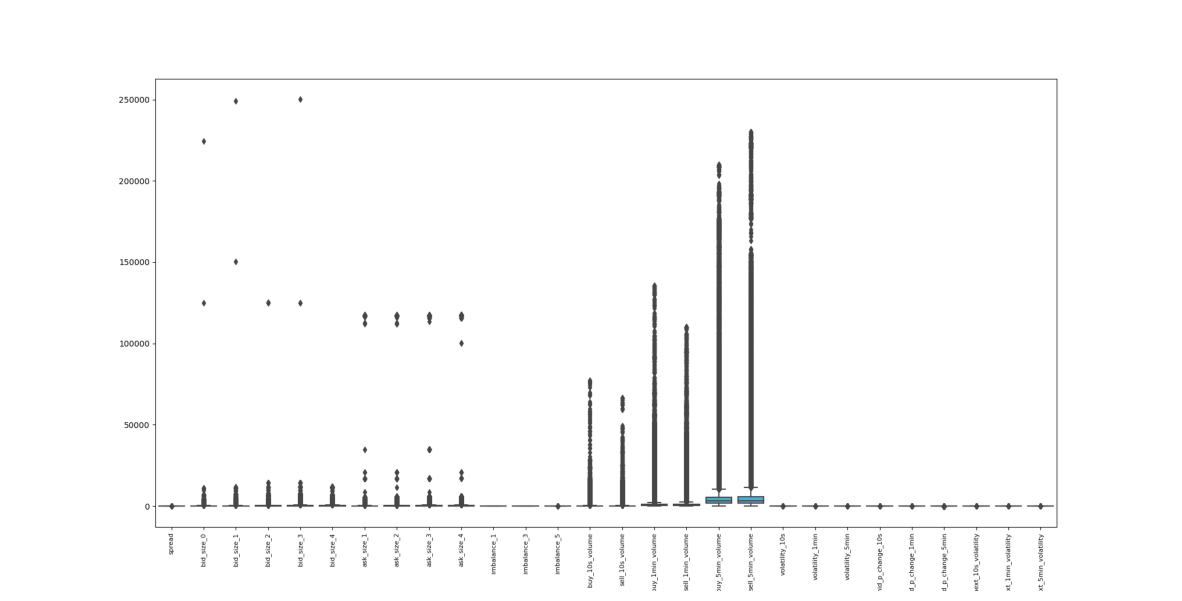

In [130]:
# Boxplots
# plt.figure(figsize=(20, 10))
# sns.boxplot(df)
# plt.xticks(fontsize=8, rotation=90)
# plt.savefig('images/boxplots_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/boxplots_all_outs.png')
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.axis('off')
plt.show()

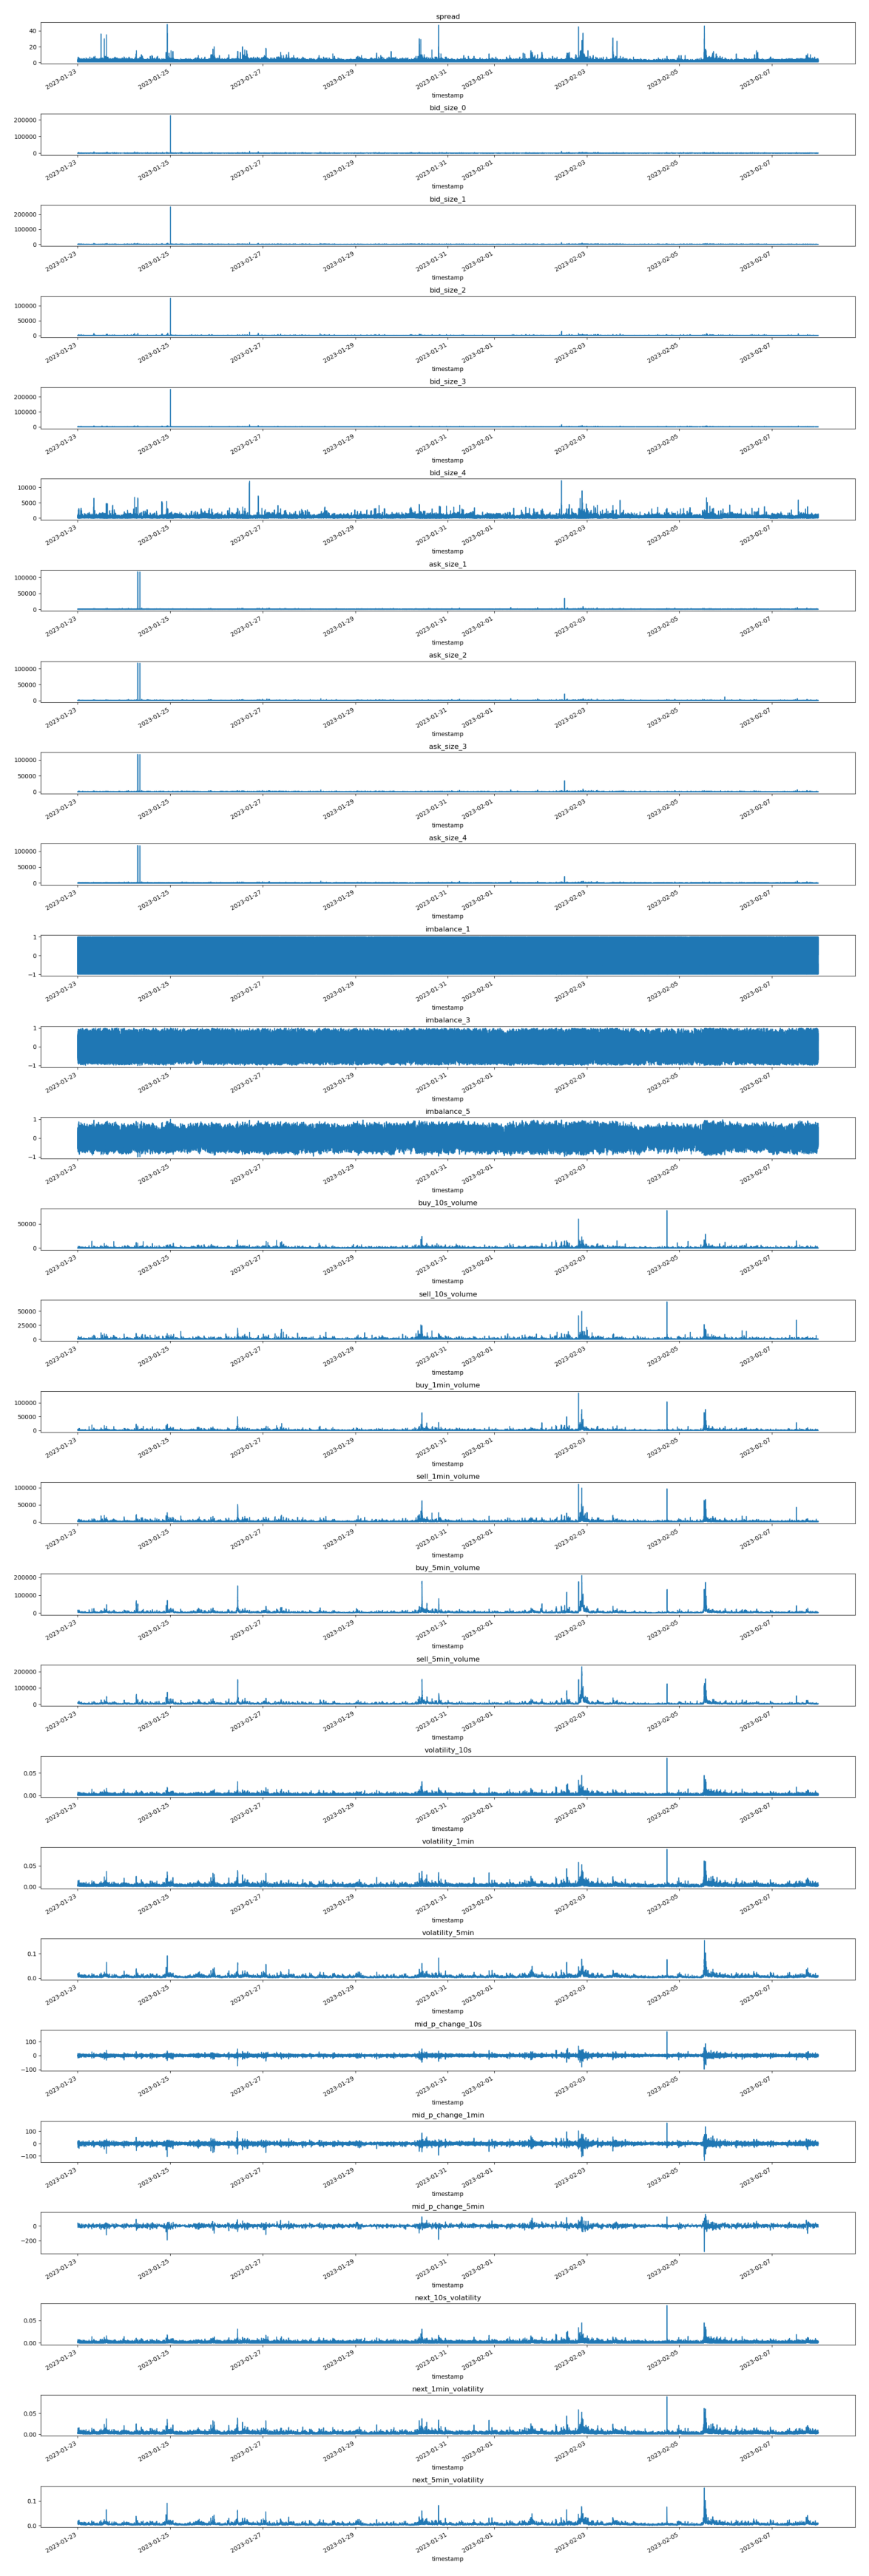

In [131]:
# Plotear líneas de cada variable:
# fig, axs = plt.subplots(len(df.columns), 1, figsize=(20, 60))
# for i, col in enumerate(df.columns):
#     df[col].plot(ax=axs[i], title=col)
# plt.tight_layout()
# plt.savefig('images/lineplots_all_outs.png', dpi='figure')
# plt.show()

# Leer la imagen del archivo
img = mpimg.imread('images/lineplots_all_outs.png')
plt.figure(figsize=(15,45))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Revisión de la granularidad

Revisamos la distribución de observaciones por horas:

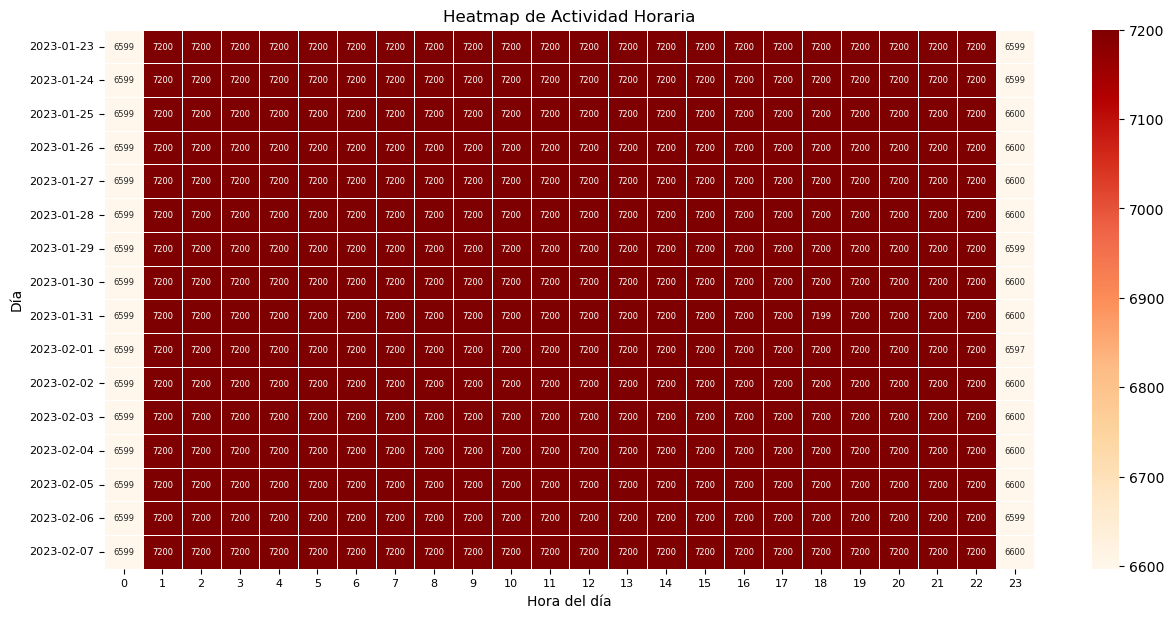

In [132]:
# Remuestrear los datos por hora y cuenta el número de registros por hora
df_resampled = df.resample('H').size().reset_index(name='count')
df_resampled.columns = ['timestamp', 'count']

# Extraer el día y la hora de la columna 'timestamp'
df_resampled['day'] = df_resampled['timestamp'].dt.date
df_resampled['hour'] = df_resampled['timestamp'].dt.hour

# Crear una tabla pivote para el heatmap
heatmap_data = df_resampled.pivot(index='day', columns='hour', values='count')

# Dibujar el heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(heatmap_data, cmap='OrRd', linewidths=0.5, annot=True, fmt=".0f", annot_kws={"size": 6})  # Ajusta el tamaño con "size"
plt.title('Heatmap de Actividad Horaria')
plt.xticks(size=8)
plt.yticks(size=8)
plt.ylabel('Día')
plt.xlabel('Hora del día')
plt.show()

La temperatura de los recuadros representa la cantidad de observaciones contenidas en cada hora, de cada día, a lo largo del dataset. Observamos una distribución consistente y homogénea, consistente con la granularidad media de 0.5 segundos, 7200 por hora.

Los recuadors de color claro indican datos faltantes, aunque también consistentes. Estos corresponden a los 10 minutos de posible cierre del sistema de recolección de datos, a medianoche todos los días.

#### Estacionareidad

La estacionariedad se refiere a una propiedad de las series de tiempo en la cual las características estadísticas (como la media, la varianza y la estructura de autocorrelación) no cambian con el tiempo. En otras palabras, una serie estacionaria tiene propiedades que son consistentes a lo largo del tiempo.

La estacionariedad es importante en el análisis de series de tiempo porque muchos métodos y modelos estadísticos asumen esta propiedad. Si una serie no es estacionaria, puede llevar a predicciones poco fiables o engañosas. Hacer que una serie sea estacionaria a menudo es un paso esencial antes de modelarla, ya que mejora la precisión y la interpretabilidad de los modelos.

Para evaluar la estacionariedad de una serie de tiempo, utilizamos la prueba de Dickey-Fuller aumentada (ADF). Esta prueba verifica la hipótesis nula (H0) de que una unidad de raíz está presente en una muestra de una serie de tiempo. Si la hipótesis nula se rechaza, se puede inferir que la serie de tiempo es estacionaria. El resultado de la prueba es un valor-p, y si este valor es menor que un nivel de significancia determinado (por ejemplo, 0.05), entonces podemos rechazar H0 y considerar que la serie es estacionaria.

Dada la gran cantidad de filas en `df` y el enorme costo computacional de la prueba, ejecutaremos `adfuller()` en una muestra del 10%.

**La evidencia sugiere que todas las variables son estacionarias. Estas fueron evaluadas en su primer 10% con la prueba de Dickey-Fuller.**

In [133]:
# from statsmodels.tsa.stattools import adfuller

# # Obtenemos la muestra del conjunto de datos:
# row_sample = int(df.shape[0] / 10)
# df_sample = df.iloc[:row_sample]

# # Ejecutamos adfuller() en cada columna del conjunto de datos y guardamos los valores-p:
# adfuller_p_values = []

# for col in df.columns:
#     p_value = adfuller(df_sample[col])[1]
#     adfuller_p_values.append(p_value)

# # Creamos un DataFrame que albergue loos valores-p de la prueba:
# adfuller_p_values_df = pd.DataFrame(
#     {'Series': df.columns,
#     'adfuller_p_values': adfuller_p_values}
# )
# # Verificamos si los valores-p son inferiores al umbral de significancia:
# adfuller_p_values_df['H0_rejected'] = adfuller_p_values_df['adfuller_p_values'] < 0.05

# # Guardamos los valores-p obtenidos en un archivo csv:
# adfuller_data = adfuller_p_values_df.to_csv('eda/adfuller_all_outs.csv')

# Imprimimos:
adfuller_data = pd.read_csv('eda/adfuller_all_outs.csv', index_col=0)
adfuller_data

,Series,adfuller_p_values,H0_rejected
0,spread,0.000000e+00,True
1,bid_size_0,0.000000e+00,True
2,bid_size_1,0.000000e+00,True
3,bid_size_2,0.000000e+00,True
4,bid_size_3,0.000000e+00,True
5,bid_size_4,0.000000e+00,True
6,ask_size_1,0.000000e+00,True
7,ask_size_2,0.000000e+00,True
8,ask_size_3,0.000000e+00,True
9,ask_size_4,0.000000e+00,True


#### Autocorrelación

In [134]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Número de variables
# n_vars = df_sample.shape[1]

# # Creamos una cuadrícula de subgráficos:
# fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(12, 4 * n_vars))

# for i, column in enumerate(df_sample.columns):
#     plot_acf(df_sample[column], lags=50, alpha=0.05, ax=axes[i, 0], title=f"ACF de {column}")
#     plot_pacf(df_sample[column], lags=50, alpha=0.05, ax=axes[i, 1], title=f"PACF de {column}")

# plt.tight_layout()
# plt.savefig('images/acf_pacf_all_outs.png', dpi='figure')
# plt.show()

# # Leer la imagen del archivo
# img = mpimg.imread('images/acf_pacf_all_outs.png')
# plt.figure(figsize=(20,100))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

### Multicolinealidad

Para detectar posible multicolinealidad entre las variables características, utilizamos el factor de inflación de la varianza (VIF). 

In [135]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

Y_list = [target_var, "mid_p_change_1min", "mid_p_change_5min", "next_10s_volatility", "next_1min_volatility", "next_5min_volatility"]

# # Y = df[Y_list]
# Y = df[target_var]

# # Definimos la variable objetivo y variables características escaladas 
# X = df.drop(columns=Y_list)

# # VIF dataframe
# vif_data_all_outs = pd.DataFrame()
# vif_data_all_outs["feature"] = X.columns

# # Calculamos VIF para cada variable característica:
# vif_data_all_outs["VIF"] = [variance_inflation_factor(X.values, i)
#                    for i
#                    in range(len(X.columns))]

# # Almacenar el DataFrame como csv: 
# vif_data_all_outs.to_csv('eda/vif_data_all_outs.csv')

# # Importar datos de VIF:
vif_data_all_outs = pd.read_csv('eda/vif_data_all_outs.csv', index_col=0)
vif_data_all_outs = vif_data_all_outs.sort_values(by="VIF")

# Imprimir VIF:
vif_data_all_outs

,feature,VIF
6,ask_size_1,1.163914
7,ask_size_2,1.233426
1,bid_size_0,1.236357
9,ask_size_4,1.296454
8,ask_size_3,1.308001
2,bid_size_1,1.403634
10,imbalance_1,1.492434
4,bid_size_3,1.765008
3,bid_size_2,1.904443
14,sell_10s_volume,2.358865


En `df` hay varias características con multicolinealidad elevada (mayores a 5). Las variables `ask_size_0` y `bid_size_4` presentaban multicolinealidad perfecta, lo que significa que una podía ser representada como una combinación lineal de la otra. Por esta razón, se elminó la primera. También, al crear nuevas variables, aparecerán varias con multicolinalidad perfecta. 

Podemos abordar el problema de multicolinealidad con don enfoques:

1. Eliminar variables con alta multicolinealidad, de mayores a menores y una por una, hasta que tengamos un subconjunto de variables con baja multicolinealidad. Para lograr este enfoque de fuerza bruta, creamos la función `drop_high_vif_vars()`. Si bien esta función elimina variables de forma automática e iterativa, es necesario considerar que puede haber variables eliminadas que sí puedan ser un aporte al modelo, por lo que es necesario utilizarla con cautela.

2. Utilizar modelos de regularización Lasso y Ridge para penalizar, los coeficientes de variables con alta multicolinealidad. 

Este último enfoque es el más eficiente en términos de eficiencia computacional. 

# Ingeniería de características

## Tratamiento de valores atípicos

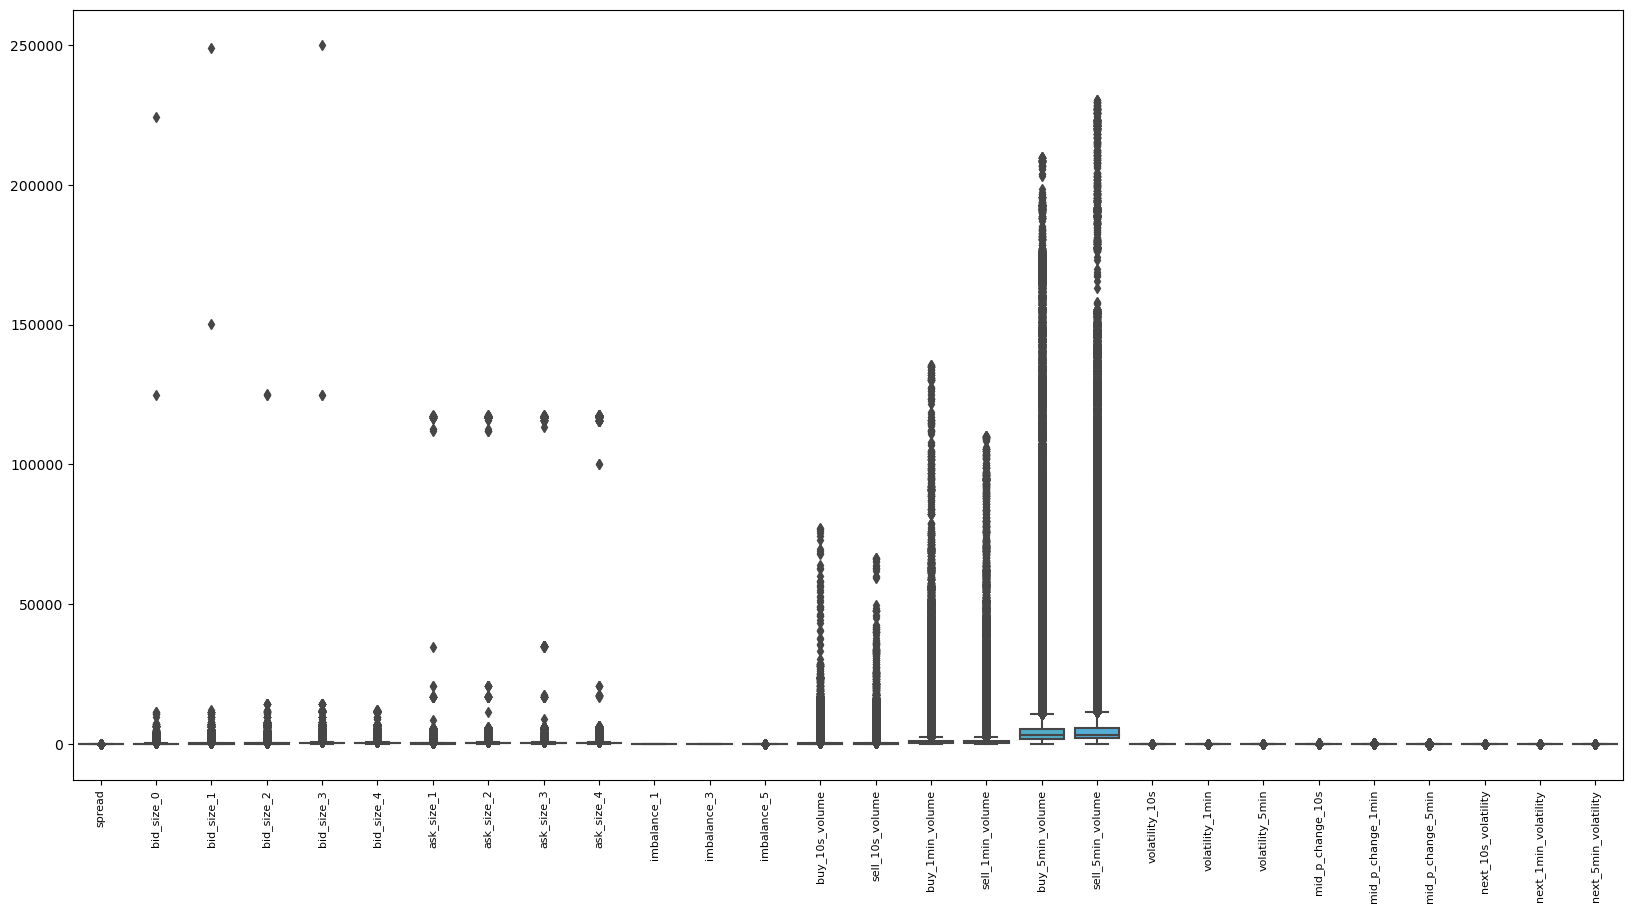

In [148]:
# Boxplots
plt.figure(figsize=(20, 10))
sns.boxplot(df)
plt.xticks(fontsize=8, rotation=90)
# plt.savefig('images/boxplots_all_outs.png', dpi='figure')
plt.show()

In [136]:
def apply_outlier_capping(series, multiplier=1.5):
    """
    Aplica capping a los valores atípicos de una serie.

    Parámetros:
    - series (pd.Series): Serie de entrada.
    - multiplier (float): Multiplicador para el IQR para determinar los límites de capping. Default es 1.5.

    Devuelve:
    - pd.Series: Serie con capping aplicado.
    """
    
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites
    upper_limit = Q3 + multiplier * IQR
    lower_limit = Q1 - multiplier * IQR

    # Aplicar capping
    series_capped = np.where(series > upper_limit, upper_limit, 
                             np.where(series < lower_limit, lower_limit, series))
    
    return pd.Series(series_capped)

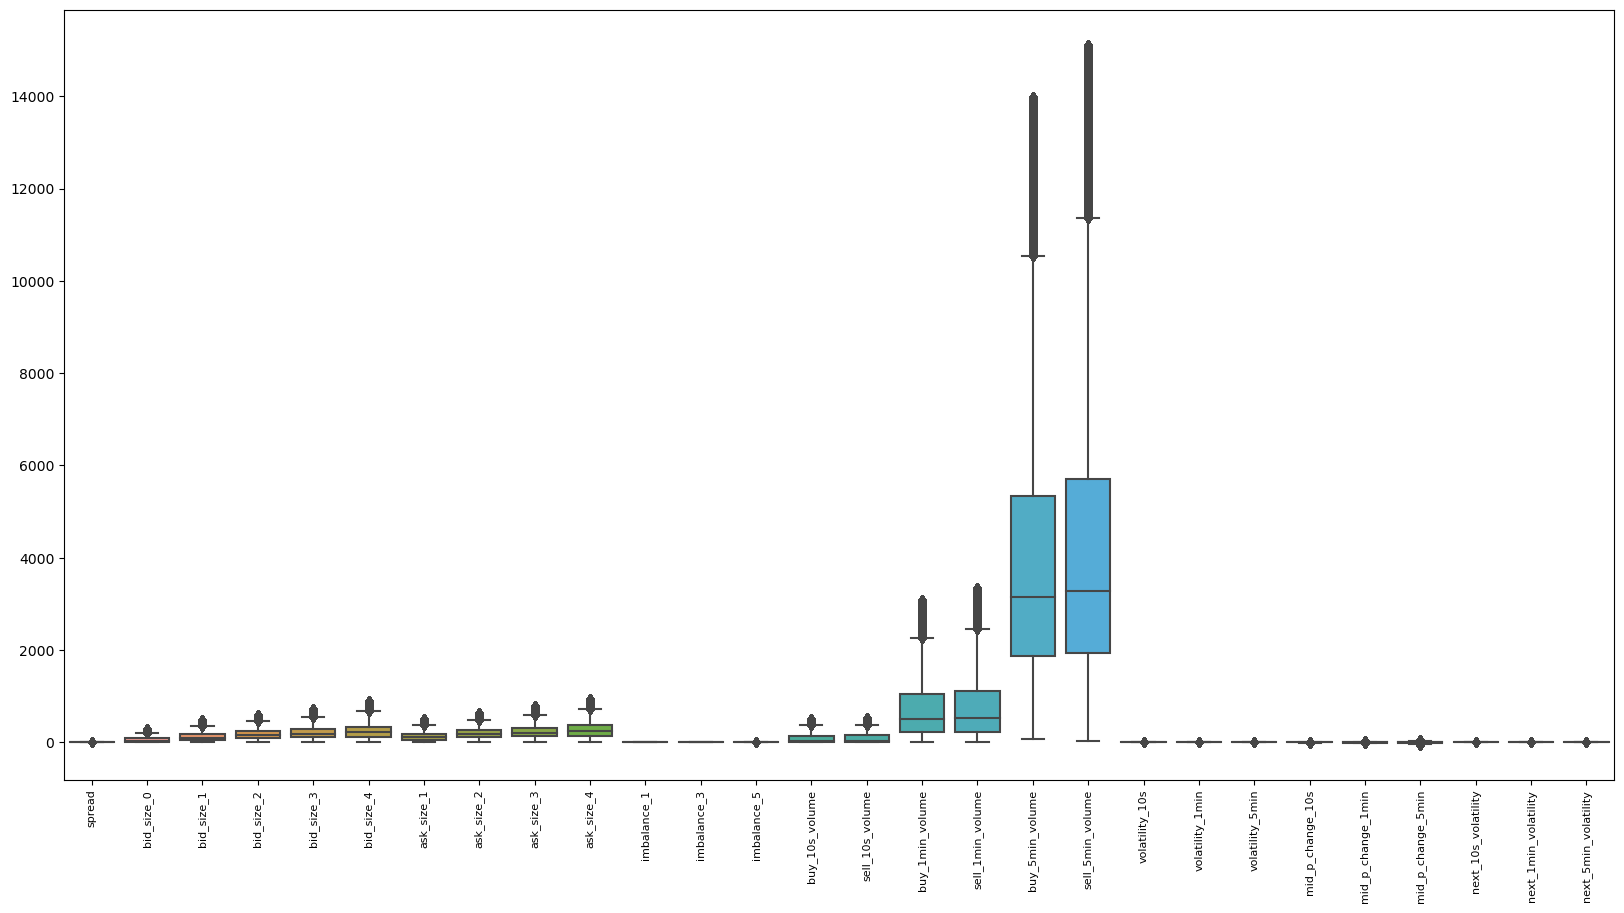

In [163]:
# df_capped = pd.DataFrame()

# multiplier = 2.5

# for col in df.columns:
#     df_capped[col] = apply_outlier_capping(df[col], multiplier=multiplier)

# # Boxplots
# plt.figure(figsize=(20, 10))
# sns.boxplot(df_capped)
# plt.xticks(fontsize=8, rotation=90)
# # plt.savefig('images/boxplots_all_outs.png', dpi='figure')
# plt.show()

In [202]:
from scipy.stats import mstats

def apply_windsorizing(series, multiplier=1.5):
    """
    Aplica windsorizing a una serie para limitar los valores atípicos.

    Parámetros:
    - series (pd.Series): La serie a la que se le aplicará windsorizing.
    - multiplier (float): Multiplicador para el IQR para determinar los límites de los valores atípicos.

    Devoluciones:
    - pd.Series: Serie con valores atípicos limitados.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    return mstats.winsorize(series, limits=[(series < lower_bound).mean(), (series > upper_bound).mean()])

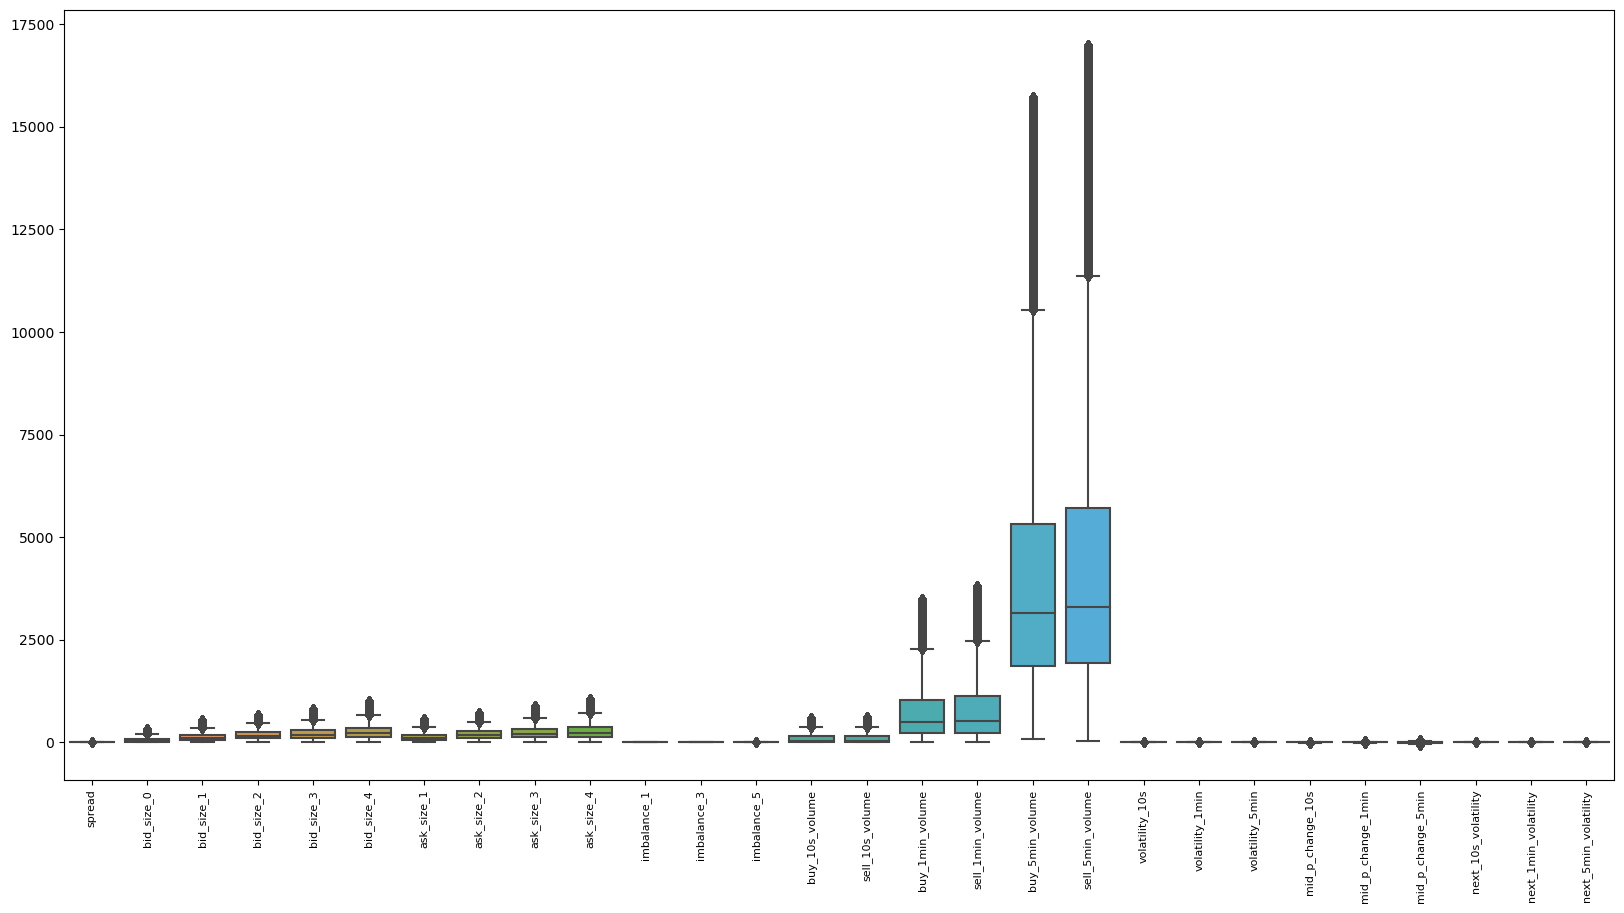

In [203]:
# df_windsorized = pd.DataFrame()

multiplier = 3

for col in df.columns:
    df[col] = apply_windsorizing(df[col], multiplier= multiplier)
    
    # Boxplots
plt.figure(figsize=(20, 10))
sns.boxplot(data=df)
plt.xticks(fontsize=8, rotation=90)
# plt.savefig('images/boxplots_all_outs.png', dpi='figure')
plt.show()

## Creación de características

In [204]:
# # Medias Móviles:
# for col in ['spread', 'buy_10s_volume', 'sell_10s_volume']:
#     for window in [10, 50, 200]:
#         df[f'{col}_ma_{window}'] = df[col].rolling(window=window).mean()

# Variables de 10 segundos
variables_10s = ['spread', 'bid_size_0', 'imbalance_1','buy_10s_volume', 'sell_10s_volume', 'volatility_10s']

for var in variables_10s:
    df[f'{var}_ma_1min'] = df[var].rolling(window=120).mean()  # Media móvil de 1 minuto
    df[f'{var}_ma_5min'] = df[var].rolling(window=600).mean()  # Media móvil de 5 minutos

# Variables de 1 minuto:
variables_1min = ['imbalance_3', 'buy_1min_volume', 'sell_1min_volume', 'volatility_1min']

for var in variables_1min:
    df[f'{var}_ma_5min'] = df[var].rolling(window=600).mean()  # Media móvil de 5 minutos

In [205]:
# Momento
df['momentum_10s'] = df['mid_p_change_10s'] - df['mid_p_change_10s'].shift(20)  # Momentum de 10 segundos basado en cambios de precio de 10 segundos
df['momentum_1min'] = df['mid_p_change_1min'] - df['mid_p_change_1min'].shift(120)  # Momentum de 1 minuto
df['momentum_5min'] = df['mid_p_change_5min'] - df['mid_p_change_5min'].shift(600)  # Momentum de 5 minutos

In [206]:
# Cambio en el Desbalance:
df['imbalance_1_change'] = df['imbalance_1'].diff()
df['imbalance_3_change'] = df['imbalance_3'].diff()
df['imbalance_5_change'] = df['imbalance_5'].diff()

In [207]:
# Relación Volumen de Compra/Venta. Nota: El divisor suma 1 para evitar valores infinitos.
df['log_buy_sell_volume_ratio_10s'] = np.log(df['buy_10s_volume'] / (df['sell_10s_volume'] + 1) + 1)
df['log_buy_sell_volume_ratio_1min'] = np.log(df['buy_1min_volume'] / (df['sell_1min_volume'] + 1) + 1)
df['log_buy_sell_volume_ratio_5min'] = np.log(df['buy_5min_volume'] / (df['sell_5min_volume'] + 1) + 1)

In [208]:
# Características Lag, creadas según lo observado en los gráficos de ACF y PACF:
for col in ['spread', 'imbalance_1', 'imbalance_3', 'imbalance_5']:
        df[f'{col}_lag_1'] = df[col].shift(1)

In [209]:
# Características de Interacción:
df['spread_imbalance1'] = df['spread'] * df['imbalance_1']

In [210]:
# Puntuación estándar para ventanas de corto (100), medio (500) y largo (3000) plazo. Nota: El divisor suma 1 para evitar valores infinitos.
df['z_score_spread_100'] = (df['spread'] - df['spread'].rolling(window=100).mean()) / (df['spread'].rolling(window=100).std() + 1)
df['z_score_spread_500'] = (df['spread'] - df['spread'].rolling(window=500).mean()) / (df['spread'].rolling(window=500).std() + 1)
df['z_score_spread_3000'] = (df['spread'] - df['spread'].rolling(window=3000).mean()) / (df['spread'].rolling(window=3000).std() + 1) 

In [211]:
# Variable "bid" acumulativa.
df['bid_total_size'] = df[['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4']].sum(axis=1)
df.drop(columns=['bid_size_0', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4'], inplace=True)

# Variable "ask" acumulativa.
df['ask_total_size'] = df[['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4']].sum(axis=1)
df.drop(columns=['ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4'], inplace=True)

# Relación Bid/Ask
df['bid_ask_ratio'] = df['bid_total_size'] / df['ask_total_size']

In [212]:
# Cálculo del Rango Verdadero (TR):
current_value = df['spread']
previous_value = df['spread'].shift(1)

# TR se calcula como el máximo entre: 
# (1) la diferencia entre el valor actual y el anterior, 
# (2) el valor absoluto entre el valor actual y el anterior, 
# (3) el valor absoluto entre el valor anterior y el actual.
df['tr'] = np.maximum(current_value - previous_value, 
                      np.maximum(np.abs(current_value - previous_value), 
                                 np.abs(previous_value - current_value)))

# Cálculo del Rango Verdadero Medio (ATR) usando un promedio móvil simple para un período de 1 hora:
window_size = 60 * 60 * 2  # 1 hora con granularidad de 0.5 segundos
df['atr'] = df['tr'].rolling(window=window_size).mean()

# Eliminar la columna 'tr' ya que es solo un cálculo intermedio:
df.drop(columns=['tr'], inplace=True)

In [213]:
# Eliminar las filas NaN generadas durante la creación de características:
df = df.dropna()

## Regularización Lasso y Ridge

Para lidiar con los problemas de selección de variables y alta multicolinealidad de los datos, ajustaremos modelos de regularización Lasso y Ridge. Lasso y Ridge son técnicas de regularización por regresión. Lasso selecciona características al hacer que algunos coeficientes sean cero, simplificando el modelo, mientras que Ridge aborda la multicolinealidad al penalizar el tamaño de los coeficientes. Ambas técnicas buscan prevenir el sobreajuste y mejorar la robustez del modelo, especialmente en presencia de muchas variables predictoras.

In [214]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Escalamos las características con la clase StandardScaler()
# scaler = StandardScaler()
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(
    df_scaled,
    columns=scaler.get_feature_names_out(df.columns)
    )

X_scaled = df_scaled.drop(columns=Y_list)
Y_scaled = df_scaled[target_var]

# Definir el tamaño del conjunto de entrenamiento
train_size = int(len(X_scaled) * 0.8)

# Dividimos los datos en conjuntos de entrenamiento y prueba:
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = Y_scaled[:train_size], Y_scaled[train_size:]

In [215]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Entrenamos el modelo Lasso
lasso_model = Lasso()
lasso_model.fit(X_train, y_train.values)
lasso_predictions = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Entrenamos el modelo Ridge
ridge_model = Ridge()
ridge_model.fit(X_train, y_train.values)
ridge_predictions = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)

print("MSE Modelo Lasso: ", lasso_mse)
print("MSE Modelo Ridge: ", ridge_mse)

MSE Modelo Lasso:  1.395926368673879
MSE Modelo Ridge:  0.4975270809313937


In [216]:
from sklearn.linear_model import LassoCV

# Definimos una lista de alphas para probar
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Creamos el modelo LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=5000)

# Ajustamos el modelo LassoCV a los datos escalados
lasso_cv.fit(X_train, y_train) # .values.ravel())

# Obtenemos el alpha óptimo para Lasso
optimal_alpha_lasso = lasso_cv.alpha_
print("Alpha óptimo para Lasso:", optimal_alpha_lasso)

# Ajustar el modelo Lasso con el alpha óptimo
lasso_opt = Lasso(alpha=optimal_alpha_lasso)
lasso_opt.fit(X_scaled, Y_scaled)

# Predecimos con el modelo Lasso:
lasso_predictions = lasso_opt.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print("MSE Lasso CV: ", lasso_mse)

Alpha óptimo para Lasso: 0.0001
MSE Lasso CV:  0.49524529489864044


In [217]:
from sklearn.linear_model import RidgeCV

# Creamos el modelo RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Ajustamos el modelo RidgeCV a los datos escalados
ridge_cv.fit(X_train, y_train) # .values.ravel())

# Obtenemos el alpha óptimo para Ridge
optimal_alpha_ridge = ridge_cv.alpha_
print("Alpha óptimo para Ridge:", optimal_alpha_ridge)

# Ajustamos el modelo Ridge con el alpha óptimo
ridge_opt = Ridge(alpha=optimal_alpha_ridge)
ridge_opt.fit(X_scaled, Y_scaled)

# Predecimos con el modelo Ridge:
ridge_predictions = ridge_opt.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print("MSE Ridge CV: ", ridge_mse)

Alpha óptimo para Ridge: 100.0
MSE Ridge CV:  0.4952614246937998


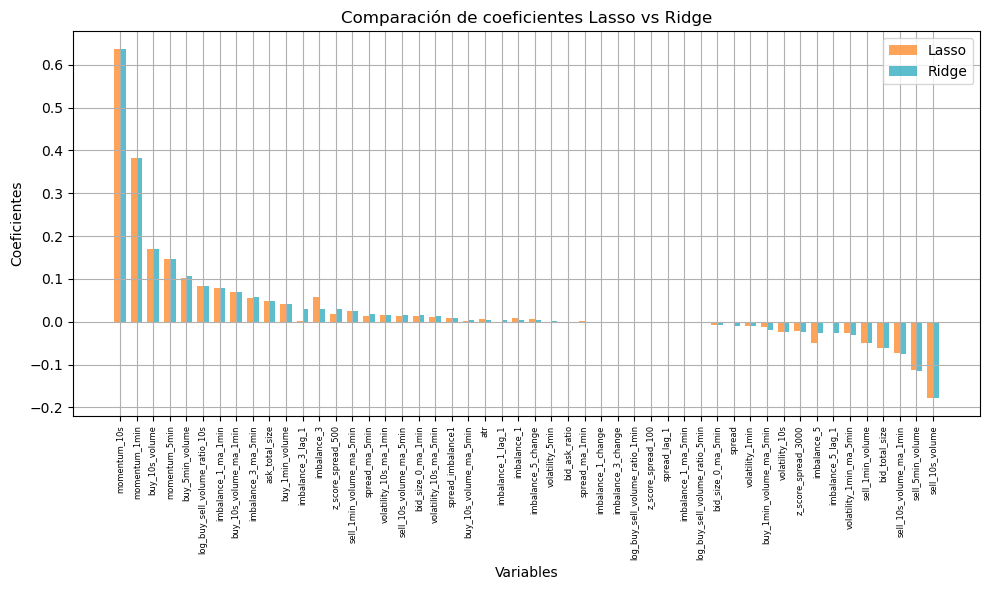

In [218]:
# Creamos un DataFrame con los coeficientes Lasso y Ridge:
regularization_coefs = pd.DataFrame(
    {'X': X_scaled.columns, 
    'lasso_coefs': lasso_opt.coef_,
    'ridge_coefs': ridge_opt.coef_}
    )

# Ordenamos el DataFrame según los coeficientes de Lasso (o Ridge) en orden descendente:
regularization_coefs = regularization_coefs.sort_values(by='ridge_coefs', ascending=False)

# Creamos un gráfico de barras comparativo:
bar_width = 0.35
index = np.arange(len(regularization_coefs['X']))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, regularization_coefs['lasso_coefs'], bar_width, label='Lasso', color='#fd7e14', alpha=0.7)
bar2 = ax.bar(index + bar_width, regularization_coefs['ridge_coefs'], bar_width, label='Ridge', color='#17a2b8', alpha=0.7)

ax.set_xlabel('Variables')
ax.set_ylabel('Coeficientes')
ax.set_title('Comparación de coeficientes Lasso vs Ridge')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(regularization_coefs['X'], rotation=90, fontsize=6)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

En los resultados previos, observamos que:

1. Los valores de MSE de ambos modelos son muy cercanos.
2. Tanto Lasso como Ridge tienen valores de coeficientes similares.
3. Existen variables con coeficientes muy pequeños. Caso especial el de la variable `ask_size_0`, que fue totalmente eliminada por el modelo Lasso. Esto es consistente con la prueba de multicolinealidad VIF y con el procedimiento de eliminación de variables con OLS robusto.

Con estos resultados en mente consideramos dos escenarios:

1. Si buscamos un modelo más simple y parsimonioso que solo incluya las variables más críticas, Lasso podría ser la mejor opción. Es especialmente útil si exiten que hay variables irrelevantes o redundantes en los datos.

2. Por otra parte, Si consideramos que todas las variables pueden tener algún grado de importancia y queremos un modelo que tenga en cuenta la multicolinealidad, Ridge podría ser más adecuado.

Para ambos casos y con base en los valores de los coeficientes Lasso y Ridge, podríamos definir un umbral de eliminación de variables adecuado. Dicho esto, **la elección final también debe basarse en el rendimiento predictivo**.

In [219]:
# Utilizar la función filtro de variables con Lasso y Ridge: 
threshold = 0.1

L1L2_X = select_features_from_regularization(
    regularization_coefs, # Matriz de coeficientes de regularización
    lasso_threshold=threshold,
    ridge_threshold=threshold
    )

# Revisar las variables seleccionadas:
L1L2_X

['sell_5min_volume',
 'sell_10s_volume',
 'buy_10s_volume',
 'momentum_1min',
 'momentum_10s',
 'buy_5min_volume',
 'momentum_5min']

## OLS robusto

Diseñaremos un modelo OLS robusto con únicamente para la variable objetivo `mid_p_change_10s`. Incorporar este modelo regresivo en el análisis exploratorio nos permitirá:

1. Inspeccionar variables sin efecto estadísticamente significativo estadística sobre la variable objetivo. La función `feature_backward_elimination()` fue creada con este propósito.
2. Retiradas las variables sin efecto significativo y también las que tienen alta multicolinealidad según `high_vif_features_list`, el OLS inspeccionar otros posibles problemas de multicolinealidad. 

In [220]:
# Obtener las variables características regularizadas con una constante:
regularized_X = df[L1L2_X]
const_regularized_X = sm.add_constant(regularized_X)

Y = df[target_var]

# Ajustamos una regresión OLS robusta con HC1 para posibles valores atípicos:
model = sm.OLS(Y, const_regularized_X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       mid_p_change_10s   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                 4.172e+05
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        15:49:41   Log-Likelihood:            -5.3158e+06
No. Observations:             2738376   AIC:                         1.063e+07
Df Residuals:                 2738368   BIC:                         1.063e+07
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0111      0.002  

**Consideraciones del modelo de OLS robusto:**

1. R-cuadrado y R-cuadrado ajustado.
2. Valores de Omnibus, Durbin-Watson y Jarque-Bera sobre la distribución del modelo.
3. Valor de condición.

## Análisis de Componentes Principales

Núm. de componentes principales que acumulan 99.0% de varianza:  5


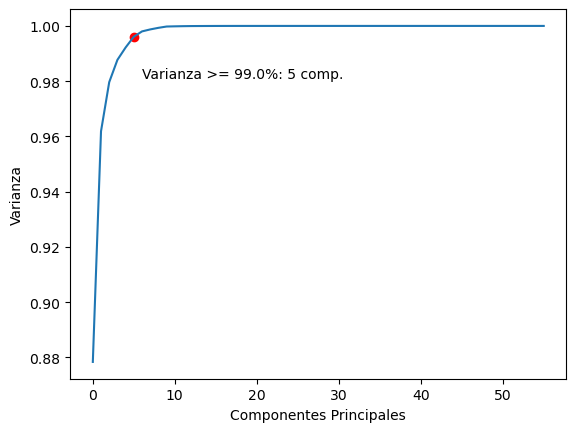

In [221]:
from sklearn.decomposition import PCA

# Instanciamos, ajustamos, transformamos y obtenemos el ratio de varianza explicada:
pca = PCA()
X_pca = pca.fit_transform(df)
exp_variance = pca.explained_variance_ratio_

# Número mínimo de componentes principales que acumulan al menos un valor requerido de varianza:

requested_variance = 0.99
exp_variance_cum_sum = np.cumsum(exp_variance)
n_components = min(np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1, len(exp_variance_cum_sum) - 1)
#n_components = np.where(exp_variance_cum_sum >= requested_variance)[0][0] + 1
print(f"Núm. de componentes principales que acumulan {requested_variance * 100}% de varianza: ", n_components)

# Graficamos:
plt.plot(exp_variance_cum_sum)
plt.scatter(n_components, exp_variance_cum_sum[n_components], color='red', marker='o')
plt.text(n_components+1, exp_variance_cum_sum[n_components]-.015, f"Varianza >= {requested_variance * 100}%: {n_components} comp.", fontsize=10)
plt.xlabel('Componentes Principales')
plt.ylabel('Varianza')
plt.show()

En la muestra tomada, la prueba de Dickey-Fuller aumentada fuertemente sugiere que las todas series son estacionarias. Este es un dato importante previo al modelado y predicción de los datos. Sin embargo, es necesario actuar con cautela, puesto que carecemos de certeza si los datos se mantienen estacionarios en todo su espacio temporal.

# Modelo Long Short-Term Memory (LSTM)

In [222]:
# Escalar las características
X_scaler = RobustScaler()
X_scaled = X_scaler.fit_transform(regularized_X)
X_scaled = pd.DataFrame(X_scaled, columns=regularized_X.columns, index=regularized_X.index)

# Transformación Yeo-Johnson sobre la variable objetivo. 
# La transformación no mejora sustancialmente la predicción pero ayuda a una convergencia más rápida.
yj_Y, lambda_best_fit = stats.yeojohnson(Y) 

# Escalar las variables objetivo
Y = pd.DataFrame(yj_Y, index=Y.index)
Y_scaler = RobustScaler()
Y_scaled = Y_scaler.fit_transform(Y)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns, index=Y.index)

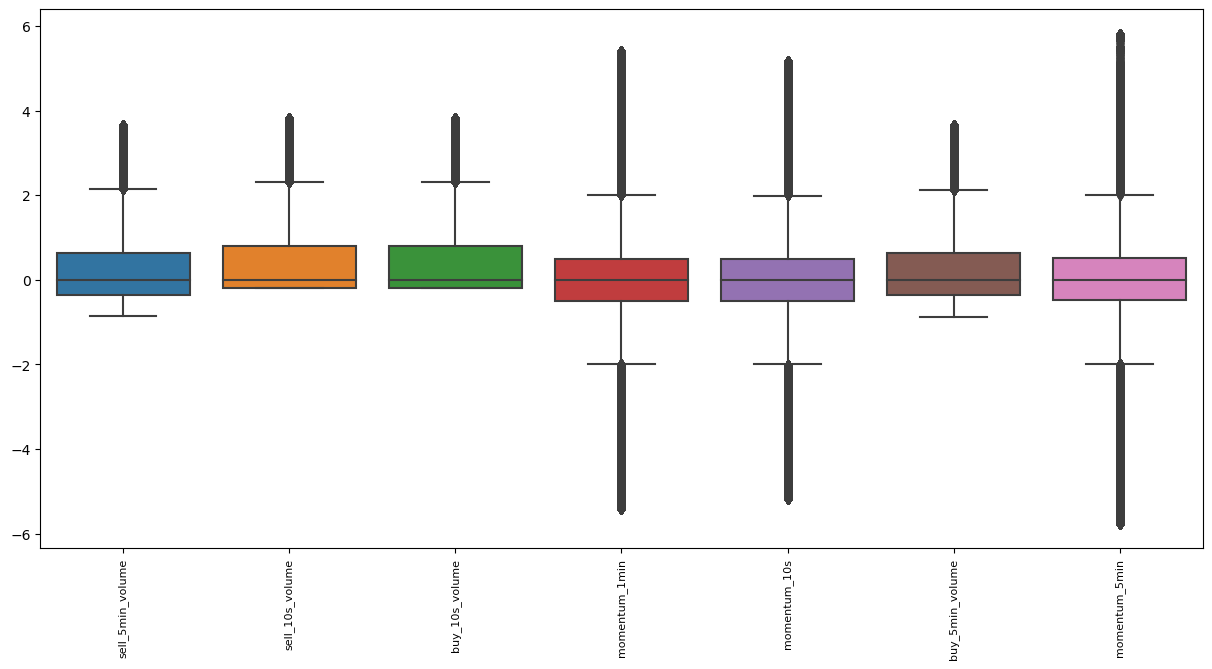

In [223]:
# Boxplots
plt.figure(figsize=(15, 7))
sns.boxplot(X_scaled)
plt.xticks(fontsize=8, rotation=90)
# plt.savefig('images/boxplots_all_outs.png', dpi='figure')
plt.show()

In [224]:
# One-hot encoding para el día de la semana:
days_encoded = pd.get_dummies(X_scaled.index.dayofweek, prefix='day')

# One-hot encoding para la hora del día:
hours_encoded = pd.get_dummies(X_scaled.index.hour, prefix='hour')

# Asegurarse de que los DataFrames codificados tengan el mismo índice que X_scaled:
days_encoded.index = X_scaled.index
hours_encoded.index = X_scaled.index

# Concatenar las columnas codificadas al DataFrame original
X_scaled = pd.concat([X_scaled, days_encoded, hours_encoded], axis=1)
X_scaled = X_scaled.astype('float32')

# Eliminar variables de día y hora de referencia (lunes y hora 0, respectivamente):
X_scaled.drop(columns=['hour_0', 'day_0'], inplace=True)

In [225]:
# X_scaled['is_outlier'] = mark_rows_with_outliers(X_scaled, multiplier=3)
# print(X_scaled['is_outlier'].mean())
print(X_scaled.columns)

Index(['sell_5min_volume', 'sell_10s_volume', 'buy_10s_volume',
       'momentum_1min', 'momentum_10s', 'buy_5min_volume', 'momentum_5min',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')


In [226]:
# Dividir los datos en entrenamiento y prueba:
train_size = int(len(X_scaled) * 0.7)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
Y_train, Y_test = Y_scaled[:train_size], Y_scaled[train_size:]

# Invertir el escalado de los datos de prueba a escala original:
Y_test_rescaled = Y_scaler.inverse_transform(Y_test)

# Dividir el conjunto de entrenamiento en entrenamiento (80% de train_size) y validación (20% de train_size)
val_size = int(train_size * 0.7)
X_train, X_val = X_train[:val_size], X_train[val_size:]
Y_train, Y_val = Y_train[:val_size], Y_train[val_size:]

# Cambiar la forma de los datos para LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Definir la cantidad de nodos de entrada y de salida:
window_size = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_scaled.shape[1]

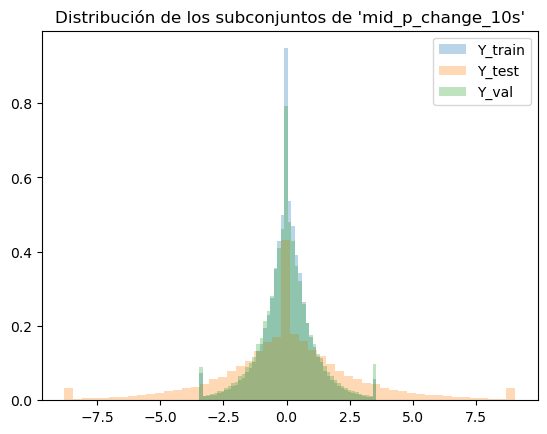

In [227]:
# Visualizar  distribución de variable objetivo:
plt.hist(Y_train, alpha=0.3, density=True, label="Y_train", bins=50)
plt.hist(Y_test_rescaled, alpha=0.3, density=True, label="Y_test", bins=50)
plt.hist(Y_val, alpha=0.3, density=True, label="Y_val", bins=50)
plt.title(f"Distribución de los subconjuntos de '{target_var}'")
plt.legend()
plt.show()

In [228]:
from scipy.stats import ks_2samp

# 2. Prueba de Kolmogorov-Smirnov para comparar las distribuciones
ks_statistic_train_test, ks_pvalue_train_test = ks_2samp(Y_train.values.ravel(), Y_test.values.ravel())
ks_statistic_train_val, ks_pvalue_train_val = ks_2samp(Y_train.values.ravel(), Y_val.values.ravel())
ks_statistic_test_val, ks_pvalue_test_val = ks_2samp(Y_test.values.ravel(), Y_val.values.ravel())

print(f"Prueba KS entre Y_train y Y_test: Estadístico = {ks_statistic_train_test:.4f}, p-valor = {ks_pvalue_train_test:.4f}")
print(f"Prueba KS entre Y_train y Y_val: Estadístico = {ks_statistic_train_val:.4f}, p-valor = {ks_pvalue_train_val:.4f}")
print(f"Prueba KS entre Y_test y Y_val: Estadístico = {ks_statistic_test_val:.4f}, p-valor = {ks_pvalue_test_val:.4f}")

Prueba KS entre Y_train y Y_test: Estadístico = 0.0274, p-valor = 0.0000
Prueba KS entre Y_train y Y_val: Estadístico = 0.0283, p-valor = 0.0000
Prueba KS entre Y_test y Y_val: Estadístico = 0.0250, p-valor = 0.0000


In [229]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

# Definir optimizador:
lr = 0.001
optimizer = Adam(learning_rate=lr)

# Dropout generalizado:
dropout = 0.3

# Iniciar la red secuencial:
lstm_model = Sequential()

# Primera capa LSTM:
lstm_model.add(
     LSTM(40,
          activation='tanh', 
          input_shape=(window_size, n_features),
          dropout=dropout,
          recurrent_dropout=dropout,
          kernel_regularizer=l2(0.1),        # Subir o bajar incrementa o disminuye el MSE de train y val, pero no disminuye la brecha
          recurrent_regularizer=l2(0.1),
          return_sequences=True  # Esto permite que la salida sea una secuencia, que alimentará la siguiente capa LSTM.
          )
     )

# Capa de dropout previa a la capa densa:
lstm_model.add(Dropout(dropout))

# Segunda capa LSTM:
lstm_model.add(
     LSTM(30,
          activation='tanh',
          dropout=dropout,
          recurrent_dropout=dropout
          )
     )

# Capa de dropout previa a la capa densa:
lstm_model.add(Dropout(dropout))

# Capa densa de salida:
lstm_model.add(Dense(n_outputs))

# Compilar el modelo:
lstm_model.compile(optimizer=optimizer, loss='mse')

In [230]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0005,
    verbose=1,
    restore_best_weights=True
    )

# Definir el checkpoint del modelo:
checkpoint = ModelCheckpoint(
    'trained_models/best_model.h5',
    monitor='val_loss',
    save_best_only=True
    )
 

# Entrenamos el modelo:
train_history = lstm_model.fit(
    X_train,
    Y_train,
    epochs=40,
    batch_size=72,
    validation_data=(X_val, Y_val),
    verbose=2,
    shuffle=False,
    callbacks=[early_stopper, checkpoint]
    )

Epoch 1/40
18637/18637 - 341s - loss: 0.6995 - val_loss: 0.6181 - 341s/epoch - 18ms/step
Epoch 2/40
18637/18637 - 335s - loss: 0.6663 - val_loss: 0.6114 - 335s/epoch - 18ms/step
Epoch 3/40
18637/18637 - 271s - loss: 0.6666 - val_loss: 0.6043 - 271s/epoch - 15ms/step
Epoch 4/40
18637/18637 - 278s - loss: 0.6659 - val_loss: 0.6077 - 278s/epoch - 15ms/step
Epoch 5/40


KeyboardInterrupt: 

In [ ]:
import json

# Guardar el modelo completo en formato HDF5:
lstm_model.save('trained_models/lstm_model_all_outs_2.h5')

# Guardar la historia como JSON:
with open('trained_models/train_history_all_outs_2.json', 'w') as file:
    json.dump(train_history.history, file)

In [ ]:
# Cargar modelo guardado:
lstm_model = load_model('trained_models/lstm_model_all_outs_2.h5')

# Cargar la historia desde JSON:
with open('trained_models/train_history_all_outs_2.json', 'r') as file:
    train_history = json.load(file)

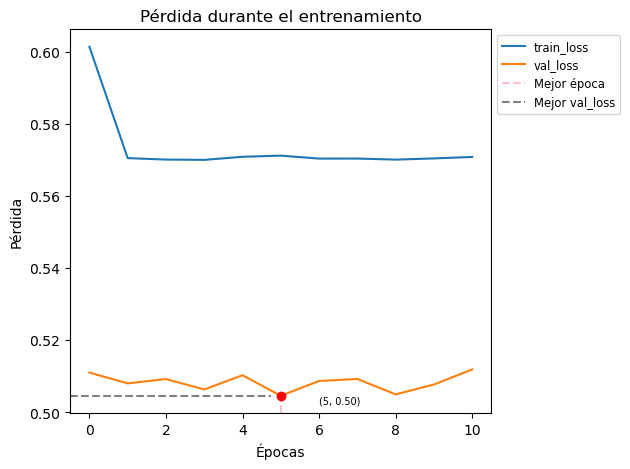

In [ ]:
train_history_df = pd.DataFrame(train_history)

# Plotear los resultados del entrenamiento:
plt.plot(train_history_df['loss'], label='train_loss')
plt.plot(train_history_df['val_loss'], label='val_loss')

# Obtener el índice (época) del mejor valor de pérdida de validación
best_epoch = train_history_df['val_loss'].idxmin()
best_loss = train_history_df['val_loss'].min()

# Agregar líneas punteadas a la coordenada de mejores época y val_loss 
y_ratio = best_loss / plt.ylim()[1]
plt.axvline(x=best_epoch, color='pink', linestyle='--',
            ymax=(best_loss - plt.ylim()[0]) / (plt.ylim()[1] - plt.ylim()[0]), label='Mejor época')
plt.axhline(y=best_loss, color='gray', linestyle='--', xmax=best_epoch/plt.xlim()[1], label='Mejor val_loss')
plt.plot(best_epoch, best_loss, 'ro')

# Mostrar los valores de mejor época y mejor pérdida como coordenadas
plt.text(best_epoch + 1, best_loss, f'({best_epoch}, {best_loss:.2f})',
         color='black', verticalalignment='top', horizontalalignment='left', fontsize=7)

plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()


In [ ]:
# Hacer predicciones
Y_pred = lstm_model.predict(X_test)

# Invertir el escalado para obtener las predicciones en la escala original:
Y_pred = Y_scaler.inverse_transform(Y_pred)

25673/25673 [==============================] - 135s 5ms/step


In [ ]:
# Obtener el MSE de entrenamiento y validación al final del entrenamiento
train_mse = train_history['loss'][-1]
val_mse = train_history['val_loss'][-1]

# MSE en el conjunto de prueba:
test_mse = lstm_model.evaluate(X_test, Y_test_rescaled)

print("RMSE entrenamiento: ", round(train_mse**(0.5), 3))
print("RMSE validación: ", round(val_mse**(0.5), 3))
print("RMSE evaluación:", round(test_mse**(0.5), 3))

# Proporciones sobre entrenamiento:
print("\n")
print("Proporción RMSE entrenamiento: ", round(train_mse**(0.5) / train_mse**(0.5), 3))
print("Proporción RMSE validación: ", round(val_mse**(0.5) / train_mse**(0.5), 3))
print("Proporción RMSE evaluación:", round(test_mse**(0.5) / train_mse**(0.5), 3))

25673/25673 [==============================] - 221s 8ms/step - loss: 4.7931
RMSE entrenamiento:  0.755
RMSE validación:  0.715
RMSE evaluación: 2.189


Proporción RMSE entrenamiento:  1.0
Proporción RMSE validación:  0.947
Proporción RMSE evaluación: 2.898


C:\Users\Iván Trejo\AppData\Local\Temp\ipykernel_20484\3431319732.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\condaenvs\dsenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


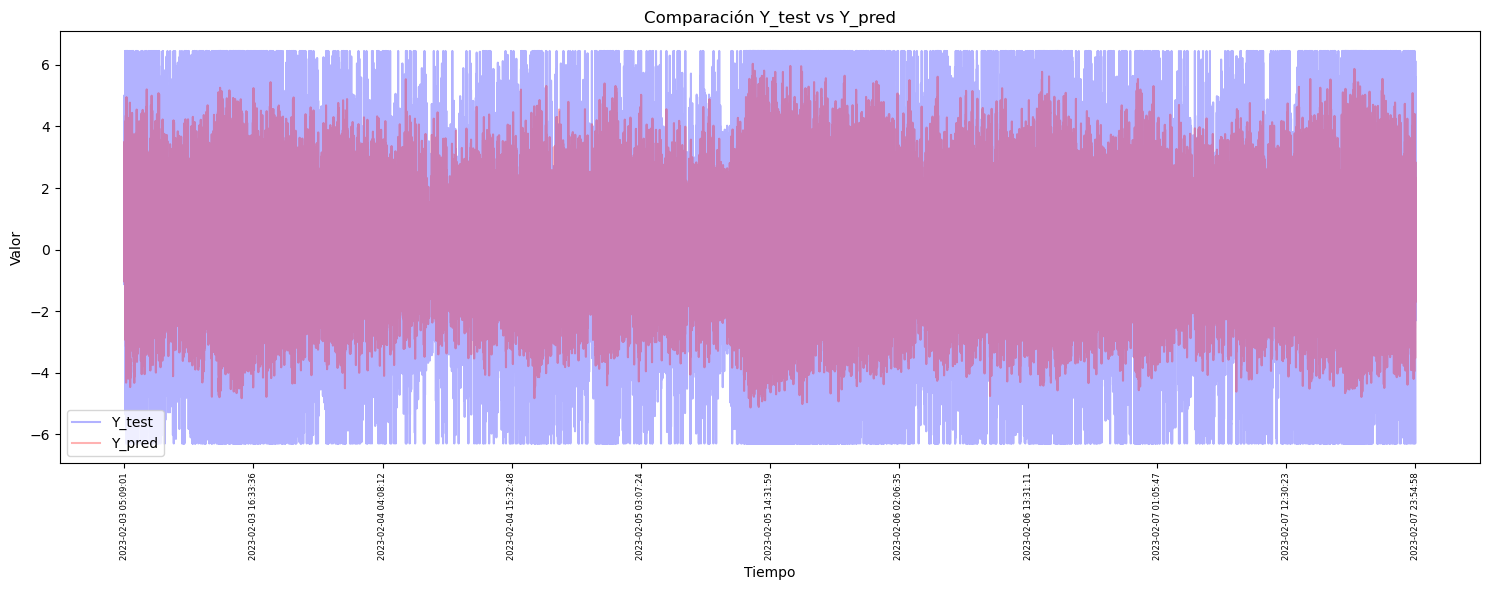

In [ ]:
plt.figure(figsize=(15, 6))

# Graficar los valores reales
plt.plot(Y_test_rescaled, label='Y_test', color='blue', alpha=0.3)

# Graficar las predicciones
plt.plot(Y_pred, label='Y_pred', color='red', alpha=0.3)

# Definir el título y las etiquetas del gráfico
plt.title('Comparación Y_test vs Y_pred')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

# Establecer las etiquetas del eje x usando el índice de tiempo de Y_test
time_labels = Y_test.index.to_list()
positions = list(range(0, len(Y_test_rescaled), len(Y_test_rescaled)//10))  # Tomar 10 puntos equidistantes para las etiquetas
selected_labels = [time_labels[i].strftime('%Y-%m-%d %H:%M:%S') for i in positions]
plt.xticks(positions, selected_labels, rotation=90, size=6)

plt.legend()
plt.tight_layout()
plt.show()